# Assignment 3: Non-Linear Classification with SVM

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia

In this assignment, you will implement your own version of SVM with kernels to classify non-linear data. For references, you may refer to my [lecture 10](https://drive.google.com/open?id=1CeBhepjDKBaFBq2BZq-zNQs-MC8ll7aL4qAF8TJ24FM) and [lecture 10b](https://drive.google.com/open?id=13BidUAs_c2QdZkf92axt2S748sbnbI9Hgxg-fzb-OuU) or Chapter 5 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_3_svm.ipynb**.


## 1. DATA SET AND VISUALIZATION FUNCTION
We will use the non-linear toy data called the Moon dataset. You may use the code snippet below to generate the train/test set. Feel free to change the number of samples, and noise level. Additionally, a function plot_svm() is provided to help you visualize the decision boundary, margin, and support vectors on the dataset in 2D feature space.

The provided function plot_svm() works out-the-box, and is the best way to visualize and evaluate the performance of your model. It assumes the classifier has an instance variable "self.support_vectors_", which is a numpy array of the support vectors found in training. DO NOT modify this function. Once your implementation in Task 3 is complete, the plots generated for your model should look similar to the plots generated for the standard library models in Task 2. 

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import precision_score, recall_score

X, y = make_moons (n_samples = 500, noise = 0.15, random_state = 49)
y = y*2-1.0 # convert the labels from {0,1} to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

import matplotlib.pyplot as plt

def plot_svm (clf, X, y, axes=[-2, 3, -2, 2]):
    """
    Generate a simple plot of SVM including the decision boundary, margin, and its training data
    
    Parameters
    ----------
    clf: your classifier handle
    X: feature matrix shape(m_samples, n_features)
    y: label vector shape(m_samples, )
    axes: (optional) the axes of the plot in format [xmin, xmax, ymin, ymax] 
    """
    # Create a mesh grid based on the provided axes (100 x 100 resolution)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s,x1s) # create a mesh grid
    X_mesh = np.c_[x0.ravel(), x1.ravel()] # convert all mesh points into 2-D points
    y_pred = clf.predict(X_mesh).reshape(x0.shape) # predict then covert back to the 2-D
    y_decision = clf.decision_function(X_mesh).reshape(x0.shape)

    plt.figsize=(16, 9)
    plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "bo", label="Class -1")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "go", label="Class +1")
    # Plot out the support vectors (in red)
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=80, c="r", label="Support Vectors")
    # Plot decision boundary and margins
    plt.contourf(x0,x1, y_pred, cmap = plt.cm.brg, alpha = 0.1)
    plt.contourf(x0,x1, y_decision, cmap = plt.cm.brg, alpha = 0.2)
    plt.contour(x0, x1, y_decision, colors='k',
                 levels=[-1, 0, 1], alpha=0.5,
                 linestyles=['--', '-', '--'])
    plt.legend(loc="lower right")
    plt.axis("auto")

    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0) 

In [2]:
X_train.shape


(400, 2)

In [3]:
X_test.shape

(100, 2)

In [4]:
y_train.shape

(400,)

In [5]:
y_test.shape

(100,)

In [6]:
print(X_train)

[[ 0.01614299  0.22029806]
 [ 1.19669383  0.19770121]
 [ 1.80105924 -0.09950022]
 [ 0.69448607 -0.26772343]
 [-0.19732429  0.85299508]
 [ 0.12534534  0.30843837]
 [ 0.64486232  1.0492189 ]
 [ 1.44864053 -0.17422605]
 [ 1.39776587  0.12148183]
 [ 2.06207544  0.43936137]
 [-1.14569998  0.04617496]
 [-0.24543054  0.11186744]
 [ 0.33352887  1.06133967]
 [ 0.10127783  0.52926691]
 [ 0.1643044  -0.11629048]
 [ 1.92939381  0.27006183]
 [ 2.03412888  0.34148378]
 [ 1.2805348  -0.33816734]
 [ 1.60427693 -0.02915155]
 [ 2.159579    0.34102531]
 [-0.86353348  0.86493563]
 [ 0.00825782  0.88270111]
 [ 0.29952539  1.03173461]
 [-0.91280947  0.5119627 ]
 [ 1.60215158 -0.06512775]
 [ 0.88258537  0.83303866]
 [ 0.32909927 -0.28310635]
 [ 0.87819254  0.16967617]
 [-0.89498142  0.28244601]
 [ 0.3569334   0.77474469]
 [ 0.77838157  0.83186648]
 [ 0.14464811  0.40305191]
 [-0.68746086  0.70197408]
 [ 1.07573349 -0.46440539]
 [ 0.80810629  0.65636528]
 [ 2.17299316  0.35628178]
 [ 0.43143125  0.0250558 ]
 

- - -
## 2. TRAIN SVM FOR CLASSIFICATION TASK 

Use the standard libarary SVM classifier (SVC) on the training data, and then test the classifier on the test data. You will need to call SVM with 3 kernels: (1) Linear, (2) Polynomial and (3) Gaussian RBF. 

You should tune each model using a grid search or similar hyperparameter selection process, and report the best hyperparameters found. You will use these same hyperparameter settings later when testing and comparing to your implementation in Task 4. Once you've selected the best hyperparameters for each kernel, you will need to report the following:

* Confusion matrix, Recall, and Precision. If applicable, discuss any tuning process on C and/or gamma to get to a reasonable result.
* Use the provided plot_svm() to visualize the SVM in 2D. This might give you some insight on how SVM determines the margin and support vector on the Moon dataset.


In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
# Your code here

default_svc=SVC()
default_svc.fit(X_train,y_train)
y_pred=default_svc.predict(X_test)
print('Default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Default hyperparameters: 0.9700


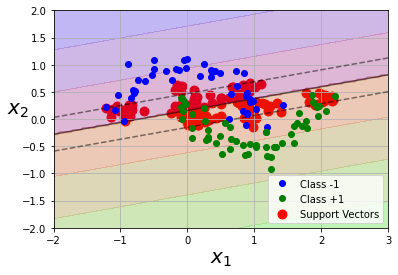

In [8]:
# Linear:
#param_grid = [{"C": np.logspace(-2, 10, 13)}]
param_grid = [{"C": [0.1, 1, 10, 100, 1000]}]
linear_svm = SVC(kernel="linear", random_state=42)
#1grid_search = GridSearchCV(linear_svm, param_grid, scoring="f1", cv=5, return_train_score=True)
#2linear_svc_plot = grid_search.estimator.fit(X_train, y_train)
#3linear_svc = grid_search.fit(X_train, y_train)
#plot_svm(linear_svc_plot, X_test, y_test)
linear_svm.fit(X_train, y_train)
plot_svm(linear_svm, X_test, y_test)

In [9]:
y_pred_test_pre=linear_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test_pre)
print('Confusion matrix\n\n', conf_matrix)
print('\nTrue Positives(TP) = ', conf_matrix[0,0])
print('\nTrue Negatives(TN) = ', conf_matrix[1,1])
print('\nFalse Positives(FP) = ', conf_matrix[0,1])
print('\nFalse Negatives(FN) = ', conf_matrix[1,0])
TP = conf_matrix[0,0]
TN = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
print("Correct prediction: ", TP+TN)
print("Incorrect prediction: ", FP+FN)
print("Recall: ", recall_score(y_test, y_pred_test_pre))
print("Precision: ", precision_score(y_test, y_pred_test_pre))

Confusion matrix

 [[35 10]
 [ 5 50]]

True Positives(TP) =  35

True Negatives(TN) =  50

False Positives(FP) =  10

False Negatives(FN) =  5
Correct prediction:  85
Incorrect prediction:  15
Recall:  0.9090909090909091
Precision:  0.8333333333333334


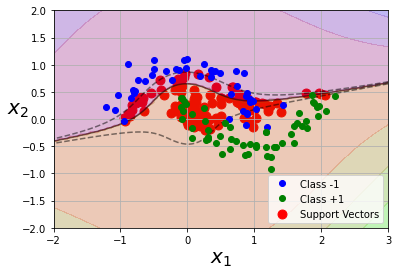

In [10]:
# Polynomial:
#param_grid = [{"C": np.logspace(-2, 10, 13)}]
param_grid = [{"C": [0.1, 1, 10, 100, 1000], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]}]
poly_svc = SVC(kernel="poly", random_state=42)
#grid_search = GridSearchCV(poly_svc, param_grid, scoring="f1", cv=5, return_train_score=True)
#poly_svc_plot = grid_search.estimator.fit(X_train, y_train)
#poly_svc = grid_search.fit(X_train, y_train)
#plot_svm(poly_svc_plot, X_test, y_test)
poly_svc.fit(X_train, y_train)
plot_svm(poly_svc, X_test, y_test)

In [11]:
y_pred_test_pre=poly_svc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test_pre)
print('Confusion matrix\n\n', conf_matrix)
print('\nTrue Positives(TP) = ', conf_matrix[0,0])
print('\nTrue Negatives(TN) = ', conf_matrix[1,1])
print('\nFalse Positives(FP) = ', conf_matrix[0,1])
print('\nFalse Negatives(FN) = ', conf_matrix[1,0])
TP = conf_matrix[0,0]
TN = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
print("Correct prediction: ", TP+TN)
print("Incorrect prediction: ", FP+FN)
print("Recall: ", recall_score(y_test, y_pred_test_pre))
print("Precision: ", precision_score(y_test, y_pred_test_pre))

Confusion matrix

 [[35 10]
 [ 1 54]]

True Positives(TP) =  35

True Negatives(TN) =  54

False Positives(FP) =  10

False Negatives(FN) =  1
Correct prediction:  89
Incorrect prediction:  11
Recall:  0.9818181818181818
Precision:  0.84375


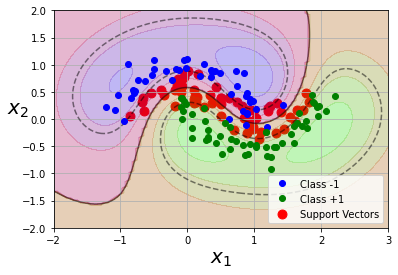

In [12]:
# #Gaussian RBF:
#param_grid = [{"C": np.logspace(-2, 10, 13)}]
param_grid = [{"C": [0.1, 1, 10, 100, 1000], "gamma":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
rbf_svc = SVC(kernel="rbf", random_state=42)
#grid_search = GridSearchCV(rbf_svc, param_grid, scoring="f1", cv=5, return_train_score=True)
#rbf_svc_plot = grid_search.estimator.fit(X_train, y_train)
##rbf_svc = grid_search.fit(X_train, y_train)
#plot_svm(rbf_svc_plot, X_test, y_test)
#plot_svm(rbf_svc_plot, X_test, y_test)
#print('Default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
rbf_svc.fit(X_train, y_train)
plot_svm(rbf_svc, X_test, y_test)

In [13]:
y_pred_test_pre=rbf_svc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test_pre)
print('Confusion matrix\n\n', conf_matrix)
print('\nTrue Positives(TP) = ', conf_matrix[0,0])
print('\nTrue Negatives(TN) = ', conf_matrix[1,1])
print('\nFalse Positives(FP) = ', conf_matrix[0,1])
print('\nFalse Negatives(FN) = ', conf_matrix[1,0])
TP = conf_matrix[0,0]
TN = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
print("Correct prediction: ", TP+TN)
print("Incorrect prediction: ", FP+FN)
print("Recall: ", recall_score(y_test, y_pred_test_pre))
print("Precision: ", precision_score(y_test, y_pred_test_pre))

Confusion matrix

 [[42  3]
 [ 0 55]]

True Positives(TP) =  42

True Negatives(TN) =  55

False Positives(FP) =  3

False Negatives(FN) =  0
Correct prediction:  97
Incorrect prediction:  3
Recall:  1.0
Precision:  0.9482758620689655


## 3. IMPLEMENT YOUR OWN NON-LINEAR SVM
Now that you see how the standard library SVM perform on the dataset, you will attempt to implement your own version of SVM. To help you, a template of SVM has been created including the quadratic optimization. Essensially, you will get the optimized value of $\alpha$ for free. Note that there are **6 subtasks** which you need to implement in order to get the SVM to work properly.

The provided code is extensively documented in comments, so that you may write code compatible with it. DO NOT edit the provided code, but read the comments and ask Piazza questions as necessary to understand it.

Many of these tasks are made much easier by a working knowledge of numpy. If you have something you want to do, but are unsure how to do it in Python, consult the numpy documentation here: https://numpy.org/doc/1.17/reference/index.html. If you haven't built a Python class before, it may be worth scanning this tutorial: https://www.datacamp.com/community/tutorials/python-oop-tutorial.

In [14]:
# Use the information from the lecture slides to formulate the SVM Kernels. 
# To help you get started, the Linear Kernel (simply just a dot product) has been provided to you. 
# These kernel functions will be called in the SVM class
# Linear Kernel             
def linear_kernel(u, v):
    return np.dot(u, v)

# Polynomial Kernel (of degree up to and including p)
def polynomial_kernel(u, v, p=3):
    # SUBTASK 1: Implement the kernel formulation here
    return np.power((np.dot(u, v)+1),p)

# Gaussian RBF Kernel
def rbf_kernel(u, v, gamma=0.1):
    # SUBTASK 2: Implement the kernel formulation here
    # Note that gamma is provided, not sigma; see the slides for the relationship between gamma and sigma
    #rbf_func_int = np.dot(u, u) + np.dot(v, v) - 2*np.dot(u, v)
    #rbf_func_inner = -gamma * rbf_func_int
    return np.exp(-gamma *np.power(np.linalg.norm(u-v),2))

In [15]:
import cvxopt # The optimization package for Quadratic Programming
import cvxopt.solvers
from sklearn.base import BaseEstimator, ClassifierMixin 
# extending these classes is required by all scikitlearn classes that will need fit, transform, and fit_transform functions
# this is what enables inclusion in pipelines and compatability with other scikitlearn structures and functions

class MySVM(BaseEstimator, ClassifierMixin):
    """The Implementation of the SVM class"""

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel # the kernel function used; this is a function and can be called
        self.C = C # make sure to set this when instantiating this class; is C is None, your performance will be weird
        if self.C is not None: self.C = float(self.C)
        self.K = None
        self.a = None
        

    def fit(self, X, y=None):
        """
        Train SVM based on the training set
        Parameters
        ----------
        X: feature matrix shape(m_samples, n_features)
        y: label vector shape(m_samples, )
        """
        
        m_samples, n_features = X.shape

        # To speed up repeated applications of the kernel function, dynamic programming is used
        # All pairs of points have the kernel function computed over them and the result stored in K
        # K is indexed by indices in X, so K[i,j] = kernel_function(X[i], X[j])
        # You may use K in your code later in this function, but are not required to
        # DO NOT edit this code
        K = np.zeros((m_samples, m_samples))
        for i in range(m_samples):
            for j in range(m_samples):
                K[i,j] = self.kernel(X[i], X[j])
        self.K = K

        # This part requires some understanding of Quadratic Programming (QP)
        # Below is the user's guide for the QP from CVXOPT 
        # http://cvxopt.org/userguide/coneprog.html#quadratic-programming
        # DO NOT edit any of this code until Subtask 3
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(m_samples) * -1)
        A = cvxopt.matrix(y, (1,m_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(m_samples) * -1))
            h = cvxopt.matrix(np.zeros(m_samples))
        else:
            tmp1 = np.diag(np.ones(m_samples) * -1)
            tmp2 = np.identity(m_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(m_samples)
            tmp2 = np.ones(m_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers for each point in X
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        # sv is a boolean array
        # sv[i] is True iff a[i] is non-zero
        sv = a > 1e-3

        # SUBTASK 3: Find the support vectors
        # note that plot_svm expects self.support_vectors_ to be a numpy array
        # you can use a Python list in your implementation, as long as you cast to a numpy array at the end of this function
        # or, you can cast to a numpy array now
        # you should add lists to store any additional metadata related to each support vector necessary later
        # for example, if you will use the Lagrange multipliers in future calculations... 
        # ...you should add an instance variable which lists the Langrage multipliers for each support vector
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.support_vectors_ = X[sv]
        self.sv_y = y[sv]

        print("%d support vectors out of %d points" % (sum(self.a), m_samples))

        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            # SUBTASK 4: Compute the Weight vector w
            for i in range(len(self.a)):
                self.w += self.a[i] * self.sv_y[i] * self.support_vectors_[i]

        else:
            # No need to compute for w in non-linear case
            # Instead, we will use alpha (a) directly to predict the labels
            self.w =  None
        
        # SUBTASK 5: Compute the Intercept b
        # b can be computed based on any arbitrary support vector
        # it is recommended that you use self.support_vectors_[0], since this will always exist
        # b should NOT be in terms of w, since w only exists in the linear case
        self.b = 0
        #for n in range(len(self.a)):
        self.b += self.sv_y[0]
        self.b -= np.sum(self.a * self.sv_y * K[ind[0],sv])
        self.b /= len(self.a)

    def decision_function(self, X):
        """The decision function is essentially w^T . x + b"""
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            # SUBTASK 6: for non-linear case, implement the kernel trick to predict label here
            # you are predicting one label for each point in X
            # note that this X may differ from the X passed to self.fit
            y_predict = np.zeros(len(X))
            
            for i in range(X.shape[0]):
              y_predict_temp = 0
              for j in range(self.support_vectors_.shape[0]):
                  y_predict_temp += self.a[j] * self.sv_y[j] * self.kernel(X[i],self.support_vectors_[j])
              y_predict[i] = y_predict_temp
            y_predit_fin = y_predict
            
            return y_predit_fin + self.b

          
    def predict(self, X):
        """Predicts -1,+1 based on the sign of the decision function"""
        return np.sign(self.decision_function(X))



---
## 4. COMPARE YOUR IMPLEMENTATION TO THE STANDARD LIBRARY
Now that you have implemented your own SVM class, let's use it! Create 3 instances of your SVM class, each with a difference kernel (Linear, Polynomial, and RBF kernel), then train and test its performance in the Moon dataset as above. You may adjust hyperparameters to achieve high performance for both the standard library and your own implementations, and report the same metrics (confusion matrix, recall, and precision). You can use the plot_svm() function to visualize your SVM with decision boundary, margin, and support vectors on the dataset, and should plot each of the three instances of your class, to compare these plots with the standard library models' plots.

Based on the number above, compare your SVM implementation with the standard library version. How did your SVM perform in comparison? Is there any major differences between the algorithms? If your performance is significantly worse, is there a different set of hyperparameters which better fits your model? Finally, reflect on your experience implementing a learning algorithm for this assignment.

     pcost       dcost       gap    pres   dres
 0: -1.3808e+02 -8.1623e+02  4e+03  2e+00  7e-15
 1: -9.4346e+01 -4.8165e+02  6e+02  2e-01  6e-15
 2: -8.9917e+01 -1.5366e+02  8e+01  2e-02  4e-15
 3: -1.0138e+02 -1.2220e+02  2e+01  6e-03  4e-15
 4: -1.0465e+02 -1.1635e+02  1e+01  3e-03  4e-15
 5: -1.0680e+02 -1.1276e+02  6e+00  1e-03  4e-15
 6: -1.0811e+02 -1.1044e+02  2e+00  4e-04  4e-15
 7: -1.0863e+02 -1.0967e+02  1e+00  8e-05  5e-15
 8: -1.0899e+02 -1.0923e+02  3e-01  2e-05  5e-15
 9: -1.0905e+02 -1.0915e+02  1e-01  3e-06  6e-15
10: -1.0909e+02 -1.0911e+02  2e-02  5e-07  6e-15
11: -1.0910e+02 -1.0910e+02  8e-04  2e-08  6e-15
12: -1.0910e+02 -1.0910e+02  8e-06  2e-10  6e-15
Optimal solution found.
114 support vectors out of 400 points
82 out of  100 predictions correct


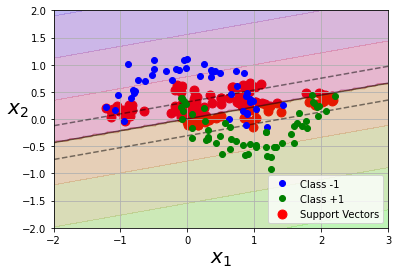

In [59]:
# Your code here
linear_svmmy = MySVM(linear_kernel, C=1)
linear_svmmy.fit(X_train, y_train)
y_predict = linear_svmmy.predict(X_test)
correct = np.sum(y_predict == y_test)
print(correct, "out of ", len(y_predict), "predictions correct")

plot_svm(linear_svmmy, X_test, y_test)

In [58]:
y_pred_test=linear_svmmy.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', conf_matrix)
print('\nTrue Positives(TP) = ', conf_matrix[0,0])
print('\nTrue Negatives(TN) = ', conf_matrix[1,1])
print('\nFalse Positives(FP) = ', conf_matrix[0,1])
print('\nFalse Negatives(FN) = ', conf_matrix[1,0])
TP = conf_matrix[0,0]
TN = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
print("Correct prediction: ", TP+TN)
print("Inorrect prediction: ", FP+FN)
print("Recall: ", recall_score(y_test, y_pred_test))
print("Precision: ", precision_score(y_test, y_pred_test))

Confusion matrix

 [[37  8]
 [10 45]]

True Positives(TP) =  37

True Negatives(TN) =  45

False Positives(FP) =  8

False Negatives(FN) =  10
Correct prediction:  82
Inorrect prediction:  18
Recall:  0.8181818181818182
Precision:  0.8490566037735849


     pcost       dcost       gap    pres   dres
 0:  1.3613e+08 -2.8412e+10  8e+10  9e-01  4e-10
 1:  2.3268e+08 -1.0651e+10  2e+10  1e-01  4e-09
 2:  2.5213e+08 -1.9154e+09  3e+09  2e-02  6e-10
 3:  1.1865e+08 -4.9191e+08  7e+08  3e-03  1e-10
 4:  3.3784e+07 -1.2374e+08  2e+08  4e-04  7e-11
 5:  1.4016e+07 -5.3737e+07  7e+07  1e-04  4e-11
 6:  5.7205e+06 -2.7381e+07  3e+07  2e-05  3e-11
 7:  1.1933e+06 -6.7129e+06  8e+06  3e-12  2e-11
 8:  2.1849e+05 -1.7412e+06  2e+06  2e-13  2e-11
 9:  1.2306e+04 -3.7407e+05  4e+05  2e-12  1e-11
10: -1.7748e+04 -1.2037e+05  1e+05  2e-13  1e-11
11: -2.4412e+04 -1.0802e+05  8e+04  5e-12  1e-11
12: -3.6427e+04 -1.0031e+05  6e+04  4e-12  6e-11
13: -4.5606e+04 -7.7241e+04  3e+04  6e-12  5e-11
14: -4.4925e+04 -7.5187e+04  3e+04  2e-13  4e-11
15: -5.0544e+04 -6.0926e+04  1e+04  9e-13  5e-11
16: -5.2842e+04 -5.6214e+04  3e+03  9e-13  4e-11
17: -5.4029e+04 -5.4430e+04  4e+02  7e-13  4e-11
18: -5.4188e+04 -5.4197e+04  9e+00  4e-13  4e-11
19: -5.4191e+04 -5.41

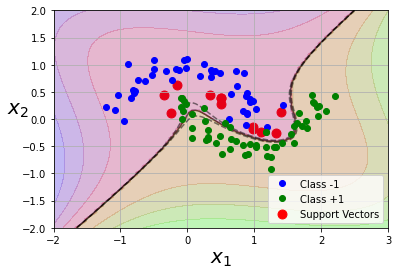

In [39]:
#param_grid = [{"C": [0.1, 1, 10, 100, 1000]}]
#for i in param_grid:
poly_svmmy = MySVM(polynomial_kernel, C=10000)
poly_svmmy.fit(X_train, y_train)
y_predict = poly_svmmy.predict(X_test)
correct = np.sum(y_predict == y_test)
print(correct, "out of ", len(y_predict), "predictions correct")
plot_svm(poly_svmmy, X_test, y_test)

In [40]:
y_pred_test=poly_svmmy.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', conf_matrix)
print('\nTrue Positives(TP) = ', conf_matrix[0,0])
print('\nTrue Negatives(TN) = ', conf_matrix[1,1])
print('\nFalse Positives(FP) = ', conf_matrix[0,1])
print('\nFalse Negatives(FN) = ', conf_matrix[1,0])
TP = conf_matrix[0,0]
TN = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
print("Correct prediction: ", TP+TN)
print("Incorrect prediction: ", FP+FN)
print("Recall: ", recall_score(y_test, y_pred_test))
print("Precision: ", precision_score(y_test, y_pred_test))

Confusion matrix

 [[45  0]
 [14 41]]

True Positives(TP) =  45

True Negatives(TN) =  41

False Positives(FP) =  0

False Negatives(FN) =  14
Correct prediction:  86
Incorrect prediction:  14
Recall:  0.7454545454545455
Precision:  1.0


     pcost       dcost       gap    pres   dres
 0: -2.0531e+02 -2.0821e+04  4e+04  4e-01  3e-14
 1: -1.6009e+02 -3.5867e+03  3e+03  3e-03  2e-14
 2: -5.9159e+02 -1.5619e+03  1e+03  6e-04  2e-14
 3: -7.0773e+02 -1.2331e+03  5e+02  3e-04  2e-14
 4: -7.7140e+02 -1.0935e+03  3e+02  1e-04  2e-14
 5: -8.0061e+02 -1.0333e+03  2e+02  6e-05  2e-14
 6: -8.2320e+02 -9.9496e+02  2e+02  4e-05  3e-14
 7: -8.2931e+02 -9.9584e+02  2e+02  3e-05  3e-14
 8: -8.5860e+02 -9.3801e+02  8e+01  1e-05  3e-14
 9: -8.7444e+02 -9.1065e+02  4e+01  3e-06  3e-14
10: -8.8259e+02 -8.9816e+02  2e+01  8e-07  3e-14
11: -8.8847e+02 -8.9011e+02  2e+00  2e-08  4e-14
12: -8.8911e+02 -8.8938e+02  3e-01  3e-09  3e-14
13: -8.8923e+02 -8.8924e+02  1e-02  5e-12  3e-14
14: -8.8924e+02 -8.8924e+02  1e-04  5e-14  4e-14
Optimal solution found.
1046 support vectors out of 400 points
89 out of  100 predictions correct


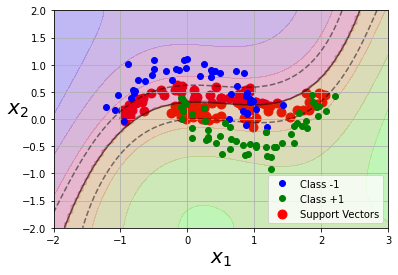

In [62]:
rbf_svmmy = MySVM(rbf_kernel, C=100)
rbf_svmmy.fit(X_train, y_train)
y_predict = rbf_svmmy.predict(X_test)
correct = np.sum(y_predict == y_test)
print(correct, "out of ", len(y_predict), "predictions correct")
plot_svm(rbf_svmmy, X_test, y_test)

In [61]:
y_pred_test=rbf_svmmy.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', conf_matrix)
print('\nTrue Positives(TP) = ', conf_matrix[0,0])
print('\nTrue Negatives(TN) = ', conf_matrix[1,1])
print('\nFalse Positives(FP) = ', conf_matrix[0,1])
print('\nFalse Negatives(FN) = ', conf_matrix[1,0])

TP = conf_matrix[0,0]
TN = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
print("Correct prediction: ", TP+TN)
print("Incorrect prediction: ", FP+FN)
print("Recall: ", recall_score(y_test, y_pred_test))
print("Precision: ", precision_score(y_test, y_pred_test))

Confusion matrix

 [[25 20]
 [ 0 55]]

True Positives(TP) =  25

True Negatives(TN) =  55

False Positives(FP) =  20

False Negatives(FN) =  0
Correct prediction:  80
Incorrect prediction:  20
Recall:  1.0
Precision:  0.7333333333333333


Based on the number above, compare your SVM implementation with the standard library version. How did your SVM perform in comparison? Is there any major differences between the algorithms? If your performance is significantly worse, is there a different set of hyperparameters which better fits your model? Finally, reflect on your experience implementing a learning algorithm for this assignment.

Linear Kernel using standard library

	Recall:  0.9090909090909091

	Precision:  0.8333333333333334

Linear Kernel using mySVM: C=1

	Recall:  0.8181818181818182

	Precision:  0.8490566037735849



Polynomial Kernel using standard library

	Recall:  0.9818181818181818

	Precision:  0.84375

Polynomial Kernel using mySVM: C=10000

	Recall:  0.7454545454545455

	Precision:  1.0



Gaussian RFBKernel using standard library

	Recall:  1.0

	Precision:  0.9482758620689655

Gaussian RFBKernel using mySUVM: C=100

	Recall:  1.0

	Precision:  0.9016393442622951


The result of my SVM function tend to be worse than the standard library one. If I include gammma and degree to my implementation, then the result might be better.

My experience on implementing a learning algorithm for this assignment is that sometime largest C (1000) or smalles C (0.1) is not always the best. C value must be test for optimization before we can say we have the best C value.

## Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [lecture 10](https://drive.google.com/open?id=1CeBhepjDKBaFBq2BZq-zNQs-MC8ll7aL4qAF8TJ24FM) and [lecture 10b](https://drive.google.com/open?id=13BidUAs_c2QdZkf92axt2S748sbnbI9Hgxg-fzb-OuU) and/or the textbook
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 3:...".

Part of the codes used in this assignment is modified from Mathieu Blondel under the 3-Clause BSD License. Best of luck and have fun!